In [4]:
import aif360.datasets as ds
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import gerryfair
from fairness_utils import *


# Adapting real-world datasets to get the score distributions and apply fairness framework





Model accuracies:

0.783

 Distribution parameters:

0.3174153944860996 1.9253445162344542
0.8545207861030307 2.065649467504403


(0.15, 0.6)

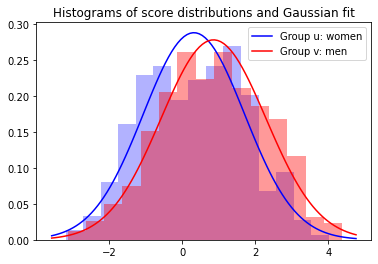

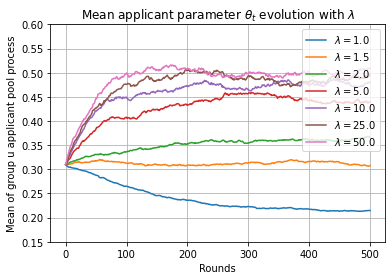

In [10]:
# German credit dataset pre-processing
label_map = {1.0: 'Good Credit', 0.0: 'Bad Credit'}
gd = ds.GermanDataset()
gd.labels[gd.labels == 2] = 0

sensitive_attr = 'sex' # or 'age'

if sensitive_attr == 'sex':
    col_idx = 0
else:
    col_idx = 1
    
idx_u = gd.protected_attributes[:,col_idx]==0
idx_v = gd.protected_attributes[:,col_idx]==1

features_u = gd.features[idx_u]
features_v = gd.features[idx_v]
labels_u = np.ravel(gd.labels[idx_u])
labels_v = np.ravel(gd.labels[idx_v])

Nu = len(labels_u)
Nv = len(labels_v)

features = gd.features
labels = np.ravel(gd.labels)

use_sensitive_attr = 1

if use_sensitive_attr == 1:

    # Using the sensitive attribute
    model = LogisticRegression(max_iter = 1000)
    model.fit(features, labels)
    fit_accuracy = model.score(features, labels)
    score = model.coef_@features.T
    
    score = np.ravel(score)
    score_u = score[idx_u]
    score_v = score[idx_v]

    mean_u,std_u=norm.fit(score_u.flatten())
    mean_v,std_v=norm.fit(score_v.flatten())
    print('\n Distribution parameters:\n')
    print(mean_u,std_u*std_u)
    print(mean_v,std_v*std_v)

    plt.figure()
    plt.hist(score_u.flatten(), bins = 15, density=True, alpha = 0.3, color = 'blue')
    plt.hist(score_v.flatten(), bins = 15, density = True, alpha = 0.4, color = 'red')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y_u = norm.pdf(x, mean_u, std_u)
    y_v = norm.pdf(x, mean_v, std_v)

    plt.plot(x, y_u, color = 'blue', label = 'Group u: women')
    plt.plot(x, y_v, color = 'red', label = 'Group v: men')
    plt.legend()
    plt.title('Histograms of score distributions and Gaussian fit')
    
else:
    # Without using the sensitive attribute
    from sklearn.linear_model import LogisticRegression
    if sensitive_attr == 'sex':
        xx = gd.features
        xx1 = xx[:,8:]
        xx2 = xx[:,0:7] 

    if sensitive_attr == 'age':
        xx = gd.features
        xx1 = xx[:,5:]
        xx2 = xx[:,0:4] 

    features = np.append(xx1,xx2, axis=1) # Without the use of gender
    labels = np.ravel(gd.labels)

    model = LogisticRegression(max_iter = 1000)
    model.fit(features, labels)
    fit_accuracy = model.score(features, labels)
    score = model.coef_@features.T
 
    score = np.ravel(score)
    score_u = score[idx_u]
    score_v = score[idx_v]

    mean_u,std_u=norm.fit(score_u.flatten())
    mean_v,std_v=norm.fit(score_v.flatten())
    print('\n Distribution parameters:\n')
    print(mean_u,std_u*std_u)
    print(mean_v,std_v*std_v)

    plt.figure()
    plt.hist(score_u.flatten(), bins = 20, density=True, alpha = 0.3, color = 'blue')
    plt.hist(score_v.flatten(), bins = 20, density = True, alpha = 0.4, color = 'red')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y_u = norm.pdf(x, mean_u, std_u)
    y_v = norm.pdf(x, mean_v, std_v)

    plt.plot(x, y_u, color = 'blue')
    plt.plot(x, y_v, color = 'red')

    plt.show()
    
    
# MDP settings
s_bar = 0.5
a_bar = 0.3
N = 100 
lambda_ = 2
eta = 0.025
theta_init = len(labels_u)/(len(labels_u)+len(labels_v)) #Initial mean of arrival process for number of minority applicants

dist_type = 'gaussian'


# Generate reward table:
state_space = np.arange(N+1)
greedy_reward_table = np.zeros((N+1,int(N*a_bar)+1))

for i in range(len(state_space)):
    greedy_reward_table[i,:] = get_greedy_reward(dist_type, mean_u, std_u, mean_v, std_v, N, a_bar, state_space[i]/N)
    

lambda_vec = np.array([1,1.5, 2, 5, 10, 25, 50])

plt.figure()
for i in range(len(lambda_vec)):
    lambda_ = lambda_vec[i]
    applicants_u, admitted_u, theta_vec, rr = process_evolution(theta_init, lambda_,eta, N, a_bar, s_bar, greedy_reward_table, 500)
    lambda_str = r'$\lambda = $'  + str(lambda_)
    plt.plot(theta_vec, label=lambda_str)
    
plt.title('Mean applicant parameter ' + r'$\theta_t$'+ ' evolution with ' + r'$\lambda$')
plt.grid()
plt.xlabel('Rounds')
plt.ylabel('Mean of group u applicant pool process')
plt.legend(loc=1)   
plt.ylim((0.15,0.6))


label feature: ['bar1']
sensitive features: ['race', 'fam_inc', 'age', 'gender']
there are 3 sensitive features including derivative features


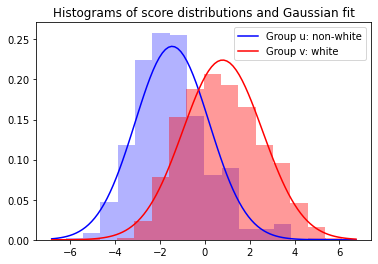

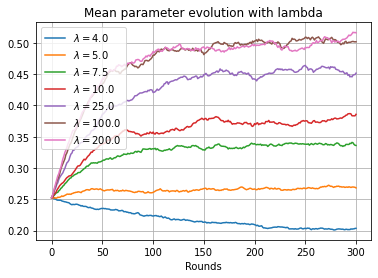

In [9]:
# Law school dataset:

dataset = "./dataset/lawschool.csv"
attributes = "./dataset/lawschool_protected.csv"
centered = False
# Process the dataset to acquire features and labels using Gerryfair's data cleaning method
X, X_prime, y = gerryfair.clean.clean_dataset(dataset, attributes, centered)

# Processing the law school admissions dataset to obtain relevant features and labels:
ff = X.values
race = ff[:,9:]
gender = ff[:,8]
race_white_vs_non_white = race[:,6] # 1-- white, 0--non-white
features = ff
labels = y.values
sensitive_attr = 'race'
idx_u = features[:,15]==0 # u --> non-white, v--> white
idx_v = features[:,15]==1
    
labels_u = np.ravel(labels[idx_u])
labels_v = np.ravel(labels[idx_v])

# Learn score distributions
model = LogisticRegression(max_iter = 1000, fit_intercept=False)
model.fit(features, labels)
fit_accuracy = model.score(features, labels)
score = model.coef_@features.T

score = np.ravel(score)
score = score.astype('float32')
score_u = score[idx_u]
score_v = score[idx_v]

mean_u,std_u=norm.fit(score_u.flatten())
mean_v,std_v=norm.fit(score_v.flatten())

plt.figure()
plt.hist(score_u.flatten(), bins = 15, density=True, alpha = 0.3, color = 'blue')
plt.hist(score_v.flatten(), bins = 15, density = True, alpha = 0.4, color = 'red')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y_u = norm.pdf(x, mean_u, std_u)
y_v = norm.pdf(x, mean_v, std_v)

plt.plot(x, y_u, color = 'blue', label = 'Group u: non-white')
plt.plot(x, y_v, color = 'red', label = 'Group v: white')
plt.legend()
plt.title('Histograms of score distributions and Gaussian fit')

# MDP settings
s_bar = 0.5
a_bar = 0.3
N = 100 
eta = 0.025
theta_init = len(labels_u)/(len(labels_u)+len(labels_v)) #Initial mean of arrival process for number of minority applicants
dist_type = 'gaussian'

# Generate reward table:
state_space = np.arange(N+1)
greedy_reward_table = np.zeros((N+1,int(N*a_bar)+1))

for i in range(len(state_space)):
    greedy_reward_table[i,:] = get_greedy_reward(dist_type, mean_u, std_u, mean_v, std_v, N, a_bar, state_space[i]/N)


lambda_vec = np.array([4,5,7.5,10,25,100,200])
plt.figure()
for i in range(len(lambda_vec)):
    lambda_ = lambda_vec[i]
    applicants_u, admitted_u, theta_vec, rr = process_evolution(theta_init, lambda_,eta, N, a_bar, s_bar, greedy_reward_table, 300)
    lambda_str = r'$\lambda = $'  + str(lambda_)
    plt.plot(theta_vec, label=lambda_str)
    
plt.title('Mean parameter evolution with lambda')
plt.grid()
plt.xlabel('Rounds')
plt.legend()    
